<a href="https://colab.research.google.com/github/allenthemartian/CNN/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision Mini)  

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101.  

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).  

Our baseline to beat is 50.76% accuracy across 101 classes.

In [ ]:
# Check to see if we're using GPU
!nvidia-smi

Wed Sep 29 04:43:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.



In [ ]:
import requests
from io import StringIO
import getpass

def pull_helper_functions(repo, path, owner="allenthemartian"):

  '''
  Args:
  
  `repo`: Name of repository
  `path`: filename/filepath
  `token`: Encrypted [GitHub Personal Access Token] Fernet Key
  `owner`: Github Account name
  
  Imports:
  
  `import requests`
  `from io import StringIO`
  `import getpass`
  '''
  token = getpass.getpass(prompt="Github Personal Access Token: ")

  r = requests.get(
    'https://api.github.com/repos/{owner}/{repo}/contents/{path}'.format(
    owner=owner, repo=repo, path=path),
    headers={
        'accept': 'application/vnd.github.v3.raw',
        'authorization': 'token {}'.format(token)
            }
    )
  
  string_io_obj = StringIO(r.text)

  with open(f"{path}", mode='w') as f:
    print(string_io_obj.getvalue(), file=f)
  
  print("Check your colab drive for file.")

In [ ]:
 pull_helper_functions(repo="TDC", path="my_custom_helper_functions.py", owner="allenthemartian")

Github Personal Access Token: ··········
Check your colab drive for file.


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-09-29 04:44:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-29 04:44:17 (53.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of Helper Functions for our notebook
from helper_functions import create_tensorboard_callback, unzip_data, compare_historys, walk_through_dir 
from my_custom_helper_functions import set_cell_size, count_params, plot_loss_curves, trainable_layers, view_random_image

## 101 Food Classes: Working with less data

Our  goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

🔑**Note:** The data we're downloading comes from the original Food101 dataset but has been preprocessed using the `image_data_modificiation` notebook.

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2021-09-29 04:44:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.181.128, 64.233.183.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.181.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   184MB/s    in 8.8s    

2021-09-29 04:44:29 (177 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [ ]:
set_cell_size(500)

# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/takoyaki'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beignets'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_roll_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tiramisu'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sashimi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tacos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/carrot_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_carbonara'.
There are 0 directories and 75 images in '

In [ ]:
# Setup data inputs  

import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # Don't shuffle test data for prediction analysis 

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train our biggest model yet with Transfer Learning on 10% of 101 Food Classes

Here are the steps we're going to take: 
* Create a ModelCheckpoint Callback
* Create a Data Augmentation Layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (We'll create our own output layer)  
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validation on 15% of the test data, to save epoch time) 

In [ ]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"  
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True) # Save model weights with the Highest Validation Accuracy  

In [ ]:
# Create Data Augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2)
  # preprocessing.Rescaling(1/255.) # Rescaling 0 <--> 1 (Required for models like ResNet50V2)
], name="data_augmentation")

In [ ]:
# Setup the base model and freeze its layers b/c this will extract features
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architeture with trainable top layers

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

x = data_augmentation(inputs) # Augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference model so weights which need to stay Frozen, stay Frozen
x = tf.keras.layers.GlobalAvgPool2D(name="global_avg_pool_layer")(x)

outputs = tf.keras.layers.Dense(units=len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# Get a summary of the model we've created
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


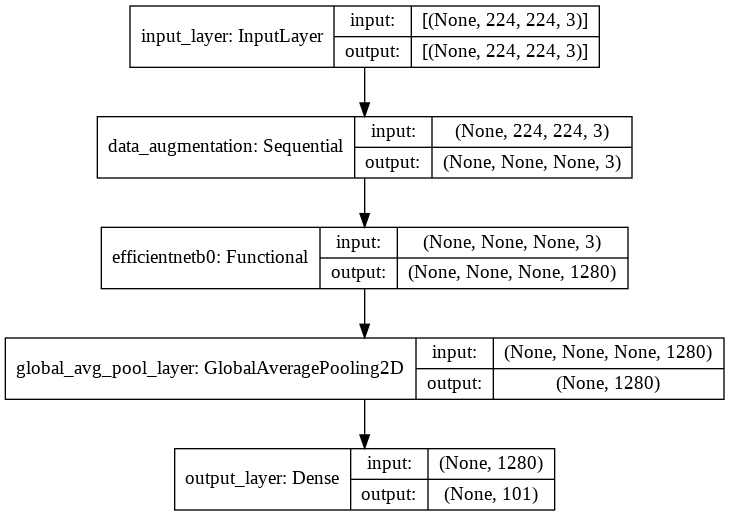

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

*So far, we've built a Transfer learning Feature Extraction Model.*

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=["accuracy"])

In [ ]:
# # Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                          #  steps_per_epoch = len(train_data_all_10_percent),
                                           validation_data = test_data,
                                           validation_steps = int(0.15 * len(test_data)), # Validate on only 15% of data during testing
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 149s 469ms/step - loss: 3.4693 - accuracy: 0.2457 - val_loss: 2.7094 - val_accuracy: 0.3673
Epoch 2/5
237/237 [==============================] - 87s 365ms/step - loss: 2.3487 - accuracy: 0.4636 - val_loss: 2.2788 - val_accuracy: 0.4417
Epoch 3/5
237/237 [==============================] - 85s 357ms/step - loss: 1.9792 - accuracy: 0.5284 - val_loss: 2.1095 - val_accuracy: 0.4677
Epoch 4/5
237/237 [==============================] - 75s 315ms/step - loss: 1.7500 - accuracy: 0.5786 - val_loss: 1.9966 - val_accuracy: 0.4852
Epoch 5/5
237/237 [==============================] - 70s 292ms/step - loss: 1.5928 - accuracy: 0.6137 - val_loss: 2.0031 - val_accuracy: 0.4796


In [ ]:
# Evaluate the model
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 97s 123ms/step - loss: 1.7299 - accuracy: 0.5456


[1.7298743724822998, 0.545623779296875]

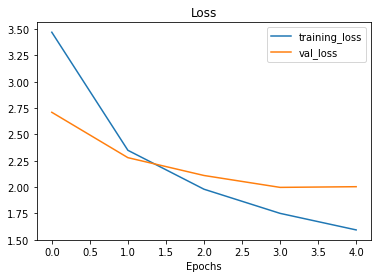

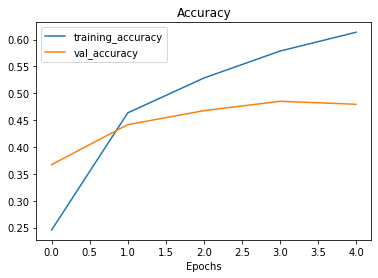

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

> ❓ **Question:** What do these curves suggest?  
> *Hint:* Ideally, these two curves should be very similar to each other (*training* and *val*)

Answer: When `val_loss` stops decreasing with a similar gradient to `training_loss`, it means the model is overfitting and **not generalizing** well. (performing too well on training data and not on unseen data).

## Fine-Tuning

1. Unfreeze all layers
2. Refreeze all layers except the ones that are needed for **Fine-Tuning**.  
3. Re-**compile** model with 10x lower *learning rate*.

In [ ]:
# # Unfreeze all of the layers in the base model
# base_model.trainable = True

# # Refreeze every layers except the last 5
# for layer in base_model.layers[:-5]:
#   layer.trainable = False

In [ ]:
from my_custom_helper_functions import freeze_layers

In [ ]:
set_cell_size()

trainable_layers(model=base_model)

|   Index | Layer Name                | Trainable   |
|---------+---------------------------+-------------|
|       0 | input_1                   | False       |
|       1 | rescaling                 | False       |
|       2 | normalization             | False       |
|       3 | stem_conv_pad             | False       |
|       4 | stem_conv                 | False       |
|       5 | stem_bn                   | False       |
|       6 | stem_activation           | False       |
|       7 | block1a_dwconv            | False       |
|       8 | block1a_bn                | False       |
|       9 | block1a_activation        | False       |
|      10 | block1a_se_squeeze        | False       |
|      11 | block1a_se_reshape        | False       |
|      12 | block1a_se_reduce         | False       |
|      13 | block1a_se_expand         | False       |
|      14 | block1a_se_excite         | False       |
|      15 | block1a_project_conv      | False       |
|      16 | block1a_project_

In [ ]:
freeze_layers(model=base_model, num_layers=5)

Check if returned model is prepared for fine-tuning.



In [ ]:
set_cell_size()

trainable_layers(base_model)

|   Index | Layer Name                | Trainable   |
|---------+---------------------------+-------------|
|       0 | input_1                   | False       |
|       1 | rescaling                 | False       |
|       2 | normalization             | False       |
|       3 | stem_conv_pad             | False       |
|       4 | stem_conv                 | False       |
|       5 | stem_bn                   | False       |
|       6 | stem_activation           | False       |
|       7 | block1a_dwconv            | False       |
|       8 | block1a_bn                | False       |
|       9 | block1a_activation        | False       |
|      10 | block1a_se_squeeze        | False       |
|      11 | block1a_se_reshape        | False       |
|      12 | block1a_se_reduce         | False       |
|      13 | block1a_se_expand         | False       |
|      14 | block1a_se_excite         | False       |
|      15 | block1a_project_conv      | False       |
|      16 | block1a_project_

In [ ]:
# Recompile model with lower learning rate (by 10x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
# What layers in the model are trainable?

trainable_layers(model)

|   Index | Layer Name            | Trainable   |
|---------+-----------------------+-------------|
|       0 | input_layer           | True        |
|       1 | data_augmentation     | True        |
|       2 | efficientnetb0        | True        |
|       3 | global_avg_pool_layer | True        |
|       4 | output_layer          | True        |


In [ ]:
# Check which layers are trainable in our base model

set_cell_size()

trainable_layers(base_model)

|   Index | Layer Name                | Trainable   |
|---------+---------------------------+-------------|
|       0 | input_1                   | False       |
|       1 | rescaling                 | False       |
|       2 | normalization             | False       |
|       3 | stem_conv_pad             | False       |
|       4 | stem_conv                 | False       |
|       5 | stem_bn                   | False       |
|       6 | stem_activation           | False       |
|       7 | block1a_dwconv            | False       |
|       8 | block1a_bn                | False       |
|       9 | block1a_activation        | False       |
|      10 | block1a_se_squeeze        | False       |
|      11 | block1a_se_reshape        | False       |
|      12 | block1a_se_reduce         | False       |
|      13 | block1a_se_expand         | False       |
|      14 | block1a_se_excite         | False       |
|      15 | block1a_project_conv      | False       |
|      16 | block1a_project_

You could unfreeze further layers for **fine-tuning** with further lower **learning rates**.

In [ ]:
# Fine-Tune for 5 more epochs
fine_tune_epochs = 5 + 5 # model has already done 5 epochs (feature extraction)
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 81s 303ms/step - loss: 1.3530 - accuracy: 0.6479 - val_loss: 1.9468 - val_accuracy: 0.4981
Epoch 6/10
237/237 [==============================] - 68s 282ms/step - loss: 1.2447 - accuracy: 0.6722 - val_loss: 1.8778 - val_accuracy: 0.5175
Epoch 7/10
237/237 [==============================] - 65s 273ms/step - loss: 1.1642 - accuracy: 0.6902 - val_loss: 1.9137 - val_accuracy: 0.5079
Epoch 8/10
237/237 [==============================] - 63s 262ms/step - loss: 1.0786 - accuracy: 0.7143 - val_loss: 1.8766 - val_accuracy: 0.5162
Epoch 9/10
237/237 [==============================] - 63s 265ms/step - loss: 1.0255 - accuracy: 0.7265 - val_loss: 1.9301 - val_accuracy: 0.5074
Epoch 10/10
237/237 [==============================] - 62s 258ms/step - loss: 0.9559 - accuracy: 0.7443 - val_loss: 1.9412 - val_accuracy: 0.5040


In [ ]:
# Evaluate on the whole test data
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 97s 123ms/step - loss: 1.6256 - accuracy: 0.5724


[1.6255970001220703, 0.5723564624786377]

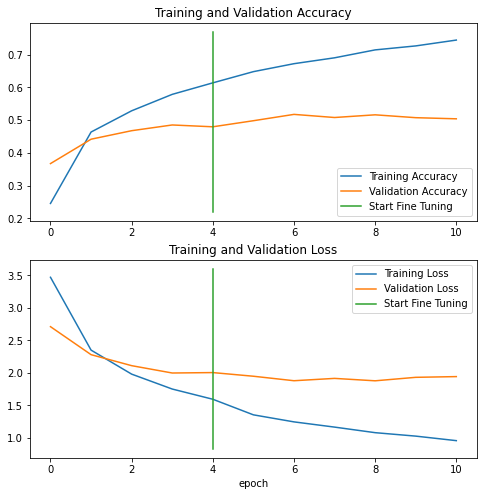

In [ ]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

It seems even after **fine-tuning**, our model's **training** metrics improved significantly, but our **validation** metrics, not so much.  

*Looks like our model is starting to* ***overfit***.  

In our case, our pre-trained model `EfficientNetB0` was trained on the `ImageNet` dataset, which contained many real life pictures of food just like our food dataset.  

If **feature extraction** already works well, the improvements you see from **fine-tuning** may not be as great as, if your dataset was siginificantly different from the data your `base_model` was pretrained on.  

In [ ]:
import sys
sys.version

'3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]'

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere.  

In [ ]:
# Save our fine-tuned model
model.save("drive/MyDrive/TDC/101_food_classes_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: drive/MyDrive/TDC/101_food_classes_10_percent_saved_big_dog_model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
set_cell_size(300)

# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/TDC/101_food_classes_10_percent_saved_big_dog_model")

In [ ]:
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 100s 125ms/step - loss: 1.6256 - accuracy: 0.5724


[1.6255970001220703, 0.5723564624786377]

In [ ]:
# The results from our loaded_model (above) should be very similar to the results below
results_all_classes_10_percent_fine_tune

[1.6255970001220703, 0.5723564624786377]

If values are not equal, *Assertion Error* will be raised.

In [ ]:
from numpy.testing import assert_almost_equal
assert_almost_equal(loaded_model_results, results_all_classes_10_percent_fine_tune)

In [ ]:
loaded_model_results == results_all_classes_10_percent_fine_tune

True

## Evaluating the performance of the big dog model across all different classes  

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.



In [ ]:
# Download pretrained model (one that was prepared by ZTM)

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-09-29 05:10:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 172.253.114.128, 108.177.121.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   142MB/s    in 0.3s    

2021-09-29 05:10:24 (142 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data(filename="/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
set_cell_size(300)
# Load in saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model

results_downloaded_model = model.evaluate(test_data)
results_downloaded_model 


790/790 [==============================] - 100s 125ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

## Making predictions with our trained model

In [ ]:
# Make predictions with our model
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 85s 105ms/step


In [ ]:
len(test_data)

790

In [ ]:
# How many predictions are there?
len(pred_probs)

25250

In [ ]:
# What's the shape of our predictions?
pred_probs.shape

(25250, 101)

In [ ]:
# Let's see what the first 10 predictions look like
pred_probs[:10]

array([[5.9541941e-02, 3.5742332e-06, 4.1376889e-02, ..., 1.4138899e-09,
        8.3530460e-05, 3.0897565e-03],
       [9.6401680e-01, 1.3753089e-09, 8.4779976e-04, ..., 5.4286684e-05,
        7.8363253e-12, 9.8467334e-10],
       [9.5925868e-01, 3.2534019e-05, 1.4867033e-03, ..., 7.1891884e-07,
        5.4398350e-07, 4.0276311e-05],
       ...,
       [4.7313324e-01, 1.2931301e-07, 1.4805583e-03, ..., 5.9749611e-04,
        6.6969820e-05, 2.3469329e-05],
       [4.4571780e-02, 4.7265351e-07, 1.2258515e-01, ..., 6.3498578e-06,
        7.5319103e-06, 3.6778715e-03],
       [7.2438985e-01, 1.9249777e-09, 5.2310857e-05, ..., 1.2291447e-03,
        1.5793171e-09, 9.6395503e-05]], dtype=float32)

In [ ]:
set_cell_size()

# What does the first prediction probability look like?
pred_probs[0]

array([5.9541941e-02, 3.5742332e-06, 4.1376889e-02, 1.0660903e-09,
       8.1613996e-09, 8.6639682e-09, 8.0926134e-07, 8.5652442e-07,
       1.9858850e-05, 8.0977554e-07, 3.1727692e-09, 9.8673388e-07,
       2.8532100e-04, 7.8049661e-10, 7.4230990e-04, 3.8915794e-05,
       6.4740016e-06, 2.4977169e-06, 3.7891397e-05, 2.0678806e-07,
       1.5538471e-05, 8.1506892e-07, 2.6230925e-06, 2.0010653e-07,
       8.3827712e-07, 5.4215743e-06, 3.7391112e-06, 1.3150788e-08,
       2.7761345e-03, 2.8051816e-05, 6.8561651e-10, 2.5574524e-05,
       1.6688934e-04, 7.6409645e-10, 4.0452869e-04, 1.3150487e-08,
       1.7957433e-06, 1.4448400e-06, 2.3062853e-02, 8.2465459e-07,
       8.5366531e-07, 1.7138503e-06, 7.0526130e-06, 1.8402382e-08,
       2.8553984e-07, 7.9482870e-06, 2.0682012e-06, 1.8525193e-07,
       3.3619781e-08, 3.1522335e-04, 1.0410886e-05, 8.5448306e-07,
       8.4741890e-01, 1.0555387e-05, 4.4094719e-07, 3.7404192e-05,
       3.5306137e-05, 3.2489079e-05, 6.7313988e-05, 1.2852399e

In [ ]:
len(pred_probs[0])

101

In [ ]:
import numpy as np

In [ ]:
# Returns the index of the maximum value of array (along an axis - ours is a 1D array)
np.argmax(pred_probs[0]), np.amax(pred_probs[0])

(52, 0.8474189)

In [ ]:
# Should add up to -> 1
np.sum(pred_probs[0])

1.0

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [ ]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)

print(f"No. of pred_probs for Sample 0: {len(pred_probs[0])}")
print(f"The class w/ the highest predicted probability for sample 0: {tf.argmax(pred_probs[0])}")

No. of pred_probs for Sample 0: 101
The class w/ the highest predicted probability for sample 0: 52


In [ ]:
test_data.class_names[52]

'gyoza'

In [ ]:
# Get the pred classes of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've get a predictions array of all our model's predictions, to evaluate them, we need to compare them to the original test dataset.

In [ ]:
test_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

`unbatch` method in TensorFlow used to unravel batches.  

```
len(test_data) = 790
```
**790 batches** of **image**, **label** tuple pairs.

In [ ]:
# To get our test data labels, we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # Look at the first 10 to check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
len(test_data)

790

In [ ]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [ ]:
results_downloaded_model

[1.8027204275131226, 0.6077623963356018]

In [ ]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

In [ ]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

In [ ]:
assert_almost_equal(actual=results_downloaded_model[1],
                    desired=sklearn_accuracy)

## Let's get visual: Making a Confusion Matrix

In [ ]:
from helper_functions import make_confusion_matrix 

In [ ]:
set_cell_size()
class_names = test_data.class_names

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(200, 200),
                      text_size=30)

We need to make changes to our `make_confusion_matrix` function to ensure the *x_labels* print vertically.

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed: (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)
  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(200, 200),
                      text_size=30,
                      savefig=True)

## Classification Report:  

Scikit-Learn has a helpful function for acquiring many different classification metrics per class (e.g *precision*, *recall* and *F1*) called **classification report**, let's try it out.  

In [ ]:
set_cell_size()

from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our model's predictions, but with so many classes, they're quite hard to understand.  

How about we create a visualization to get a better understanding?  

In [ ]:
set_cell_size()

# Get a dictionary of the classification report
classification_report_dict = classification_report(y_true = y_labels,
                                                   y_pred = pred_classes,
                                                   output_dict = True)  

classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

In [ ]:
class_names[70]

'pad_thai'

In [ ]:
classification_report_dict["70"]

{'f1-score': 0.7101200686106347,
 'precision': 0.6216216216216216,
 'recall': 0.828,
 'support': 250}

In [ ]:
classification_report_dict["70"]["f1-score"]

0.7101200686106347

In [ ]:
set_cell_size()

# Let's plot all of our F1-Scores

# Create empty dictionary
class_f1_scores = {}  

# Loop through classification report items
for key, value in classification_report_dict.items():
  # Cut off the report at "accuracy"
  if key == "accuracy":
    break 
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(key)]] = value["f1-score"]# index on class names

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
# Turn f1-scores into dataframe for visualization purposes
import pandas as pd
f1_scores = pd.DataFrame({"class_names" : list(class_f1_scores.keys()),
                          "f1-score" : list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [ ]:
f1_scores

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

In [ ]:
f1_scores[:10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

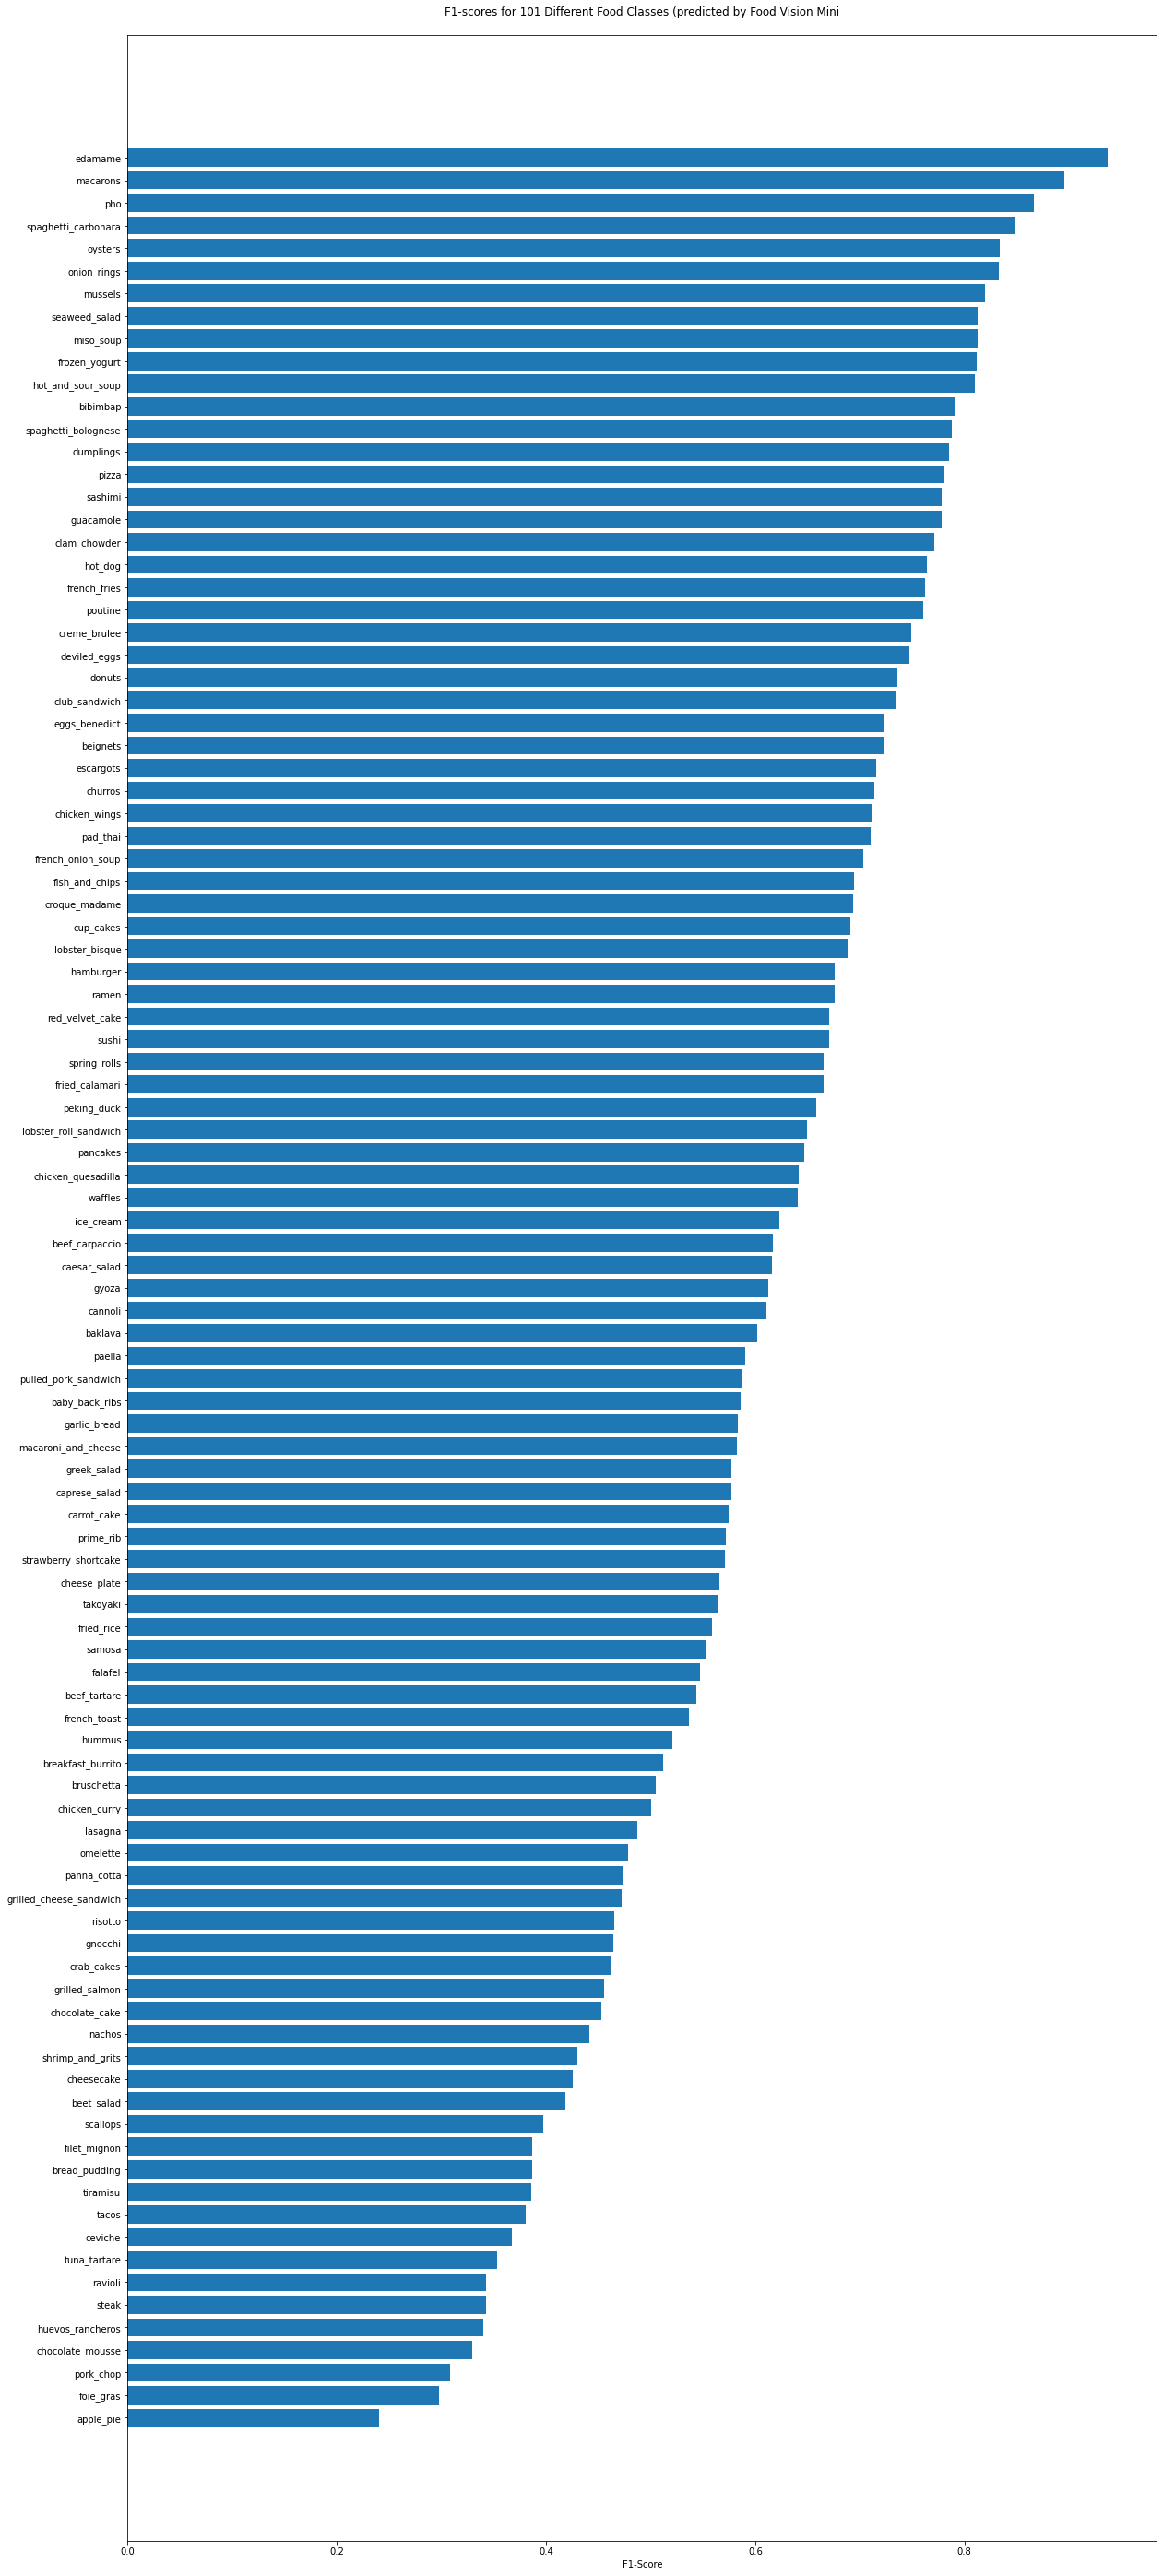

In [ ]:
plt.figure(figsize=(20, 50))

plt.barh(y=f1_scores["class_names"], width=f1_scores["f1-score"])
plt.xlabel("F1-Score")
plt.gca().invert_yaxis()
plt.title('F1-scores for 101 Different Food Classes (predicted by Food Vision Mini\n');

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

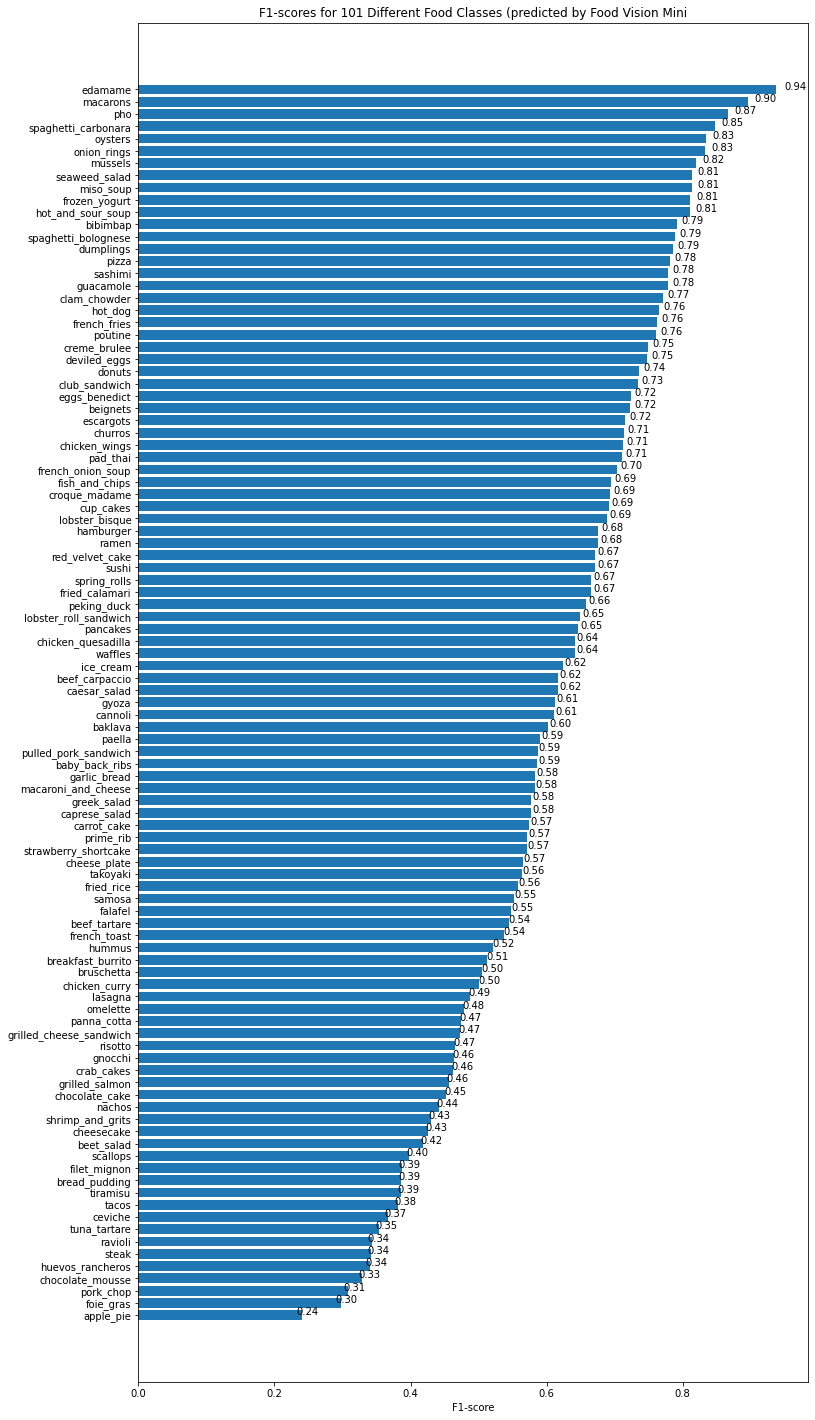

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(y=range(len(f1_scores)), width = f1_scores["f1-score"].values) # Get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"]);
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision Mini")
ax.invert_yaxis();  

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [ ]:
pred_classes

array([ 52,   0,   0, ..., 100,  94, 100])

## Visualizing predictions on custom images

How does our model perform on food images **not** even in our test dataset.  

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:

* Read in a target image filepath using `tf.io.read_file()`  
* Turn the image into Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using `tf.image.resize()`  
* Scale the image to get all the of the pixel values between 0 & 1 (if necessary)

In [ ]:
# Create a function to load and prepare images

def load_and_prep_image(filename, img_shape=224, scale=True):
  
  '''
  Reads in an image from filename, turns it into a tensor and reshapes
  into specified shape (img_shape, img_shape, color_channels=3)

  Args:
    `filename` (str): path to target image
    `image_shape` (int): height/width dimension of target image size
    `scale` (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)  

    Note: Don't need to rescale images for EfficientNet, 
          Leave true for models like ResNet50V2
  '''
  #(Read in only JPEG *not* PNG -> b/c 4 color_channels)
  # Read in the image
  img = tf.io.read_file(filename)  

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3) #if we read in a PNG, `dec...` would convert from 4 channels to 3

  # Resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])  

  # Scale? [Yes/No] (Normalization)
  if scale:
    # rescale the image (get all values between 0<->1)
    return img/255.
  else:
    return img

Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target labels and our model's predictions.  

Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the **model's predictions**, **prediction probability** and **truth label**.


In [ ]:
train_data_all_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

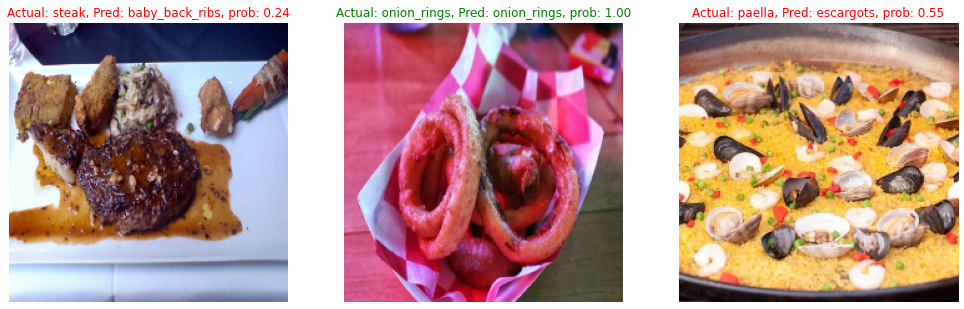

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename
  # print(filepath)
  
  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # EfficientNet does not need scaling
  # print(img.shape)
  img_expanded = tf.expand_dims(img, axis=0)
  # print(img_expanded.shape)
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # Get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it to `class_names` list
  # print(pred_prob)
  # print(pred_class)

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"Actual: {class_name}, Pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions  

View the wrong predictions with the highest prediction probability (**highest loss**)  

Can reveal insights:
  * Data issues(wrong labels)
  * Confusing classes  
    * Get better/more diverse data OR merge classes.

*Referred to as **Active Learning** where a human is involved in using a model to make predictions and fix existing labels.*  

To find our where our model is most wrong, let's write some code to find out the following:  

1. Get all of the image file paths in the test dataset using [`list_files()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) method. 
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.  
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).  
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).  
5. Visualize the images with the highest prediction probability *but have the wrong prediction.* 


In [ ]:
# 1. Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())

filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path":filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # Get the maximum prediction probability
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})

pred_df

img_path  ...      y_pred_classname
0      b'/content/101_food_classes_10_percent/test/ap...  ...                 gyoza
1      b'/content/101_food_classes_10_percent/test/ap...  ...             apple_pie
2      b'/content/101_food_classes_10_percent/test/ap...  ...             apple_pie
3      b'/content/101_food_classes_10_percent/test/ap...  ...  pulled_pork_sandwich
4      b'/content/101_food_classes_10_percent/test/ap...  ...             prime_rib
...                                                  ...  ...                   ...
25245  b'/content/101_food_classes_10_percent/test/wa...  ...               waffles
25246  b'/content/101_food_classes_10_percent/test/wa...  ...          cheese_plate
25247  b'/content/101_food_classes_10_percent/test/wa...  ...               waffles
25248  b'/content/101_food_classes_10_percent/test/wa...  ...  strawberry_shortcake
25249  b'/content/101_food_classes_10_percent/test/wa...  ...               waffles

[25250 rows x 6 columns]

In [ ]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"] # BOOLEAN

pred_df.head()

img_path  ...  pred_correct
0  b'/content/101_food_classes_10_percent/test/ap...  ...         False
1  b'/content/101_food_classes_10_percent/test/ap...  ...          True
2  b'/content/101_food_classes_10_percent/test/ap...  ...          True
3  b'/content/101_food_classes_10_percent/test/ap...  ...         False
4  b'/content/101_food_classes_10_percent/test/ap...  ...         False

[5 rows x 7 columns]

In [ ]:
set_cell_size()

# 4. Sort our DataFrame to have most wrong predictions at the top

top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  ...  pred_correct
21810  b'/content/101_food_classes_10_percent/test/sc...  ...         False
231    b'/content/101_food_classes_10_percent/test/ap...  ...         False
15359  b'/content/101_food_classes_10_percent/test/lo...  ...         False
23539  b'/content/101_food_classes_10_percent/test/st...  ...         False
21400  b'/content/101_food_classes_10_percent/test/sa...  ...         False
24540  b'/content/101_food_classes_10_percent/test/ti...  ...         False
2511   b'/content/101_food_classes_10_percent/test/br...  ...         False
5574   b'/content/101_food_classes_10_percent/test/ch...  ...         False
17855  b'/content/101_food_classes_10_percent/test/pa...  ...         False
23797  b'/content/101_food_classes_10_percent/test/su...  ...         False
18001  b'/content/101_food_classes_10_percent/test/pa...  ...         False
11642  b'/content/101_food_classes_10_percent/test/ga...  ...         False
10847  b'/content/101_food_classes_10_percent/test/fr...  ...         False
23631  b'/content/101_food_classes_10_percent/test/st...  ...         False
1155   b'/content/101_food_classes_10_percent/test/be...  ...         False
10854  b'/content/101_food_classes_10_percent/test/fr...  ...         False
23904  b'/content/101_food_classes_10_percent/test/su...  ...         False
7316   b'/content/101_food_classes_10_percent/test/cu...  ...         False
13144  b'/content/101_food_classes_10_percent/test/gy...  ...         False
10880  b'/content/101_food_classes_10_percent/test/fr...  ...         False

[20 rows x 7 columns]

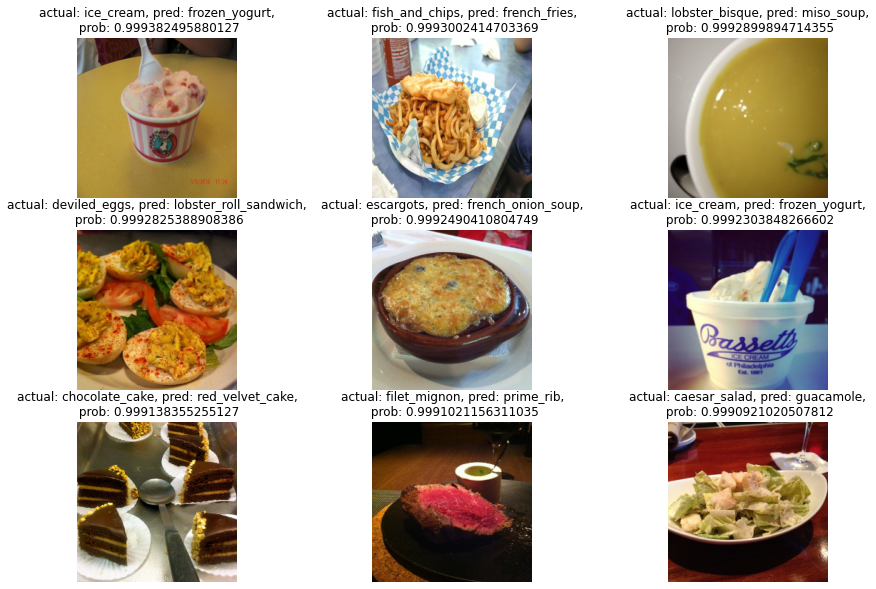

In [ ]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability

images_to_view = 9
start_index = 30

plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname},\n prob: {pred_prob}")
  plt.axis(False)

## Test out the big dog model on our own custom images

In [ ]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2021-09-29 06:29:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2021-09-29 06:29:00 (107 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
unzip_data("custom_food_images.zip")

In [ ]:
# Get the custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/pizza-dad.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg']

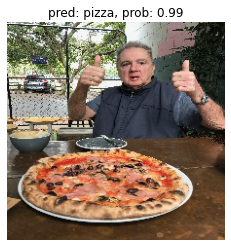

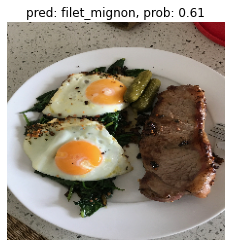

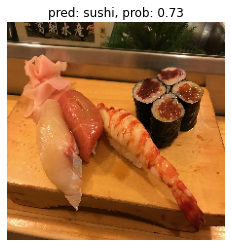

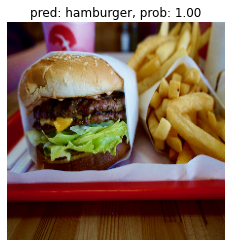

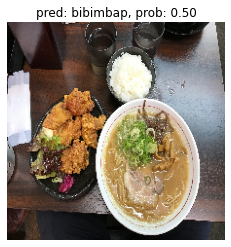

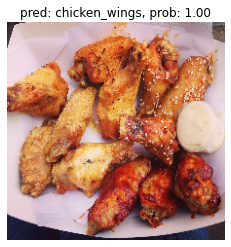

In [ ]:
# Make predictions on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # Don't need to scale for our EfficientNetB0 model
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = model.predict(img_expanded) # Make prediction on image with shape [1, 224, 224, 3] (same shape image as the model was trained on)
  pred_class = class_names[np.argmax(pred_prob)] # Get the index with the highest prediction probability
  
  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)